In [5]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
magnetic_field = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

#disp_x=0.12

                                        


In [6]:



num_particles=1
delta_values=[5e-4,-5e-4]

offset_dp=0.05

disp_values=np.linspace(-17.5, 17.5, num=100)
# Initialize empty list for sum of cooling times
sum_action_reduction = []
for delta_loop in (delta_values):
    action_reduction=[]
    for disp in tqdm(disp_values):
        
        disp_x=disp
        

        arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                                    beta_x_0=beta_x, beta_x_1=beta_x,
                                    beta_y_0=beta_y,  beta_y_1=beta_y,
                                    alpha_x_0=0,   alpha_x_1=0,
                                    alpha_y_0=0,   alpha_y_1=0,
                                    disp_x_0=disp_x,disp_x_1=disp_x,
                                    disp_y_0=0,    disp_y_1=0,
                                    beta_s=1*1e40,
                                    Q_s=0,
                                    chroma_x=0.0, chroma_y=0)

        delta_single=delta_loop
        
        particles = xp.Particles(
                
                mass0=mass0,
                p0c=p0c,
                x=disp_x*delta_single,
                px=0,
                y=0,
                py=0,
                delta=delta_single,
                zeta=0)
        
    
        cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                magnetic_field=magnetic_field,B_ratio=B_ratio,
                                                Neutralisation_space_charge=1,
                                                offset_dp=offset_dp)

            

        num_turns = int(1*1e3)
                #step = int(num_turns/100)

                
        action_x=[]
        # loop over turns
        for turn in tqdm(range(num_turns), desc='Cooling Progress', leave=False):
            action_x_temp = (particles.x ** 2 / beta_x + beta_x * particles.px ** 2)
            action_x.append(action_x_temp)

            # track particle
            arc.track(particles)
            cooler.track(particles)

        action_reduction_temp=action_x[-1]/action_x[0]
        action_reduction.append(action_reduction_temp)

    # Create a folder if it doesn't exist
    import os
    if not os.path.exists('data_results'):
        os.makedirs('data_results')

    # Save the variables to a compressed .npz file in the folder
    np.savez(f'data_results/action_reduction_dispersion{delta_loop}.npz', disp_values=disp_values, action_reduction=action_reduction)
    # Add cooling_time to sum_cooling_time
    sum_action_reduction.append(action_reduction)

total_action_reduction=np.add(sum_action_reduction[0],sum_action_reduction[1]).flatten()
total_action_reduction=total_action_reduction/2

100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


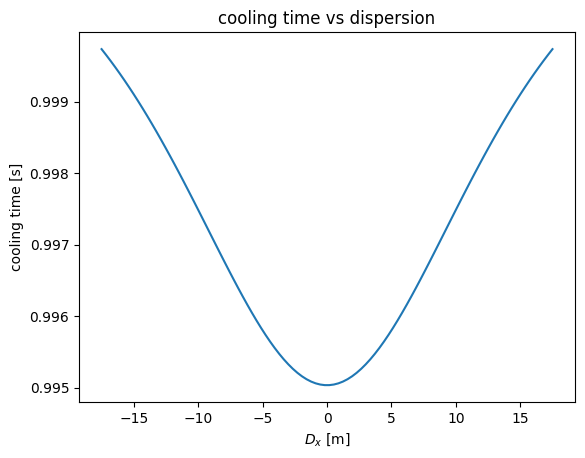

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(disp_values,action_reduction)
plt.xlabel(r'$D_x$ [m]')
plt.ylabel('cooling time [s]')
plt.title(r'cooling time vs dispersion')
plt.show()


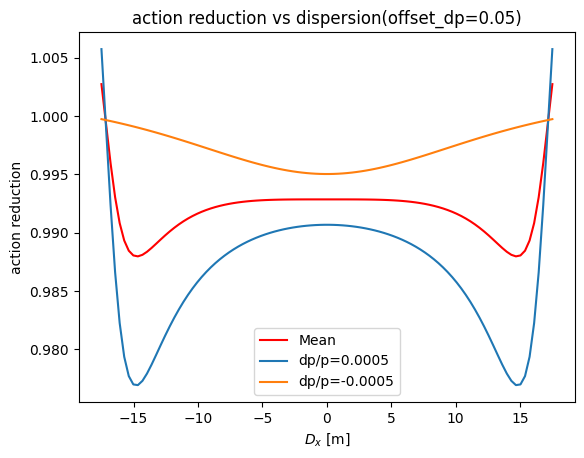

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()


plt.plot(disp_values, total_action_reduction, label='Mean',color='red')
#plt.axhline(1)
for delta in delta_values:
# Your code to generate disp_values and cooling_time
    data = np.load(f'data_results/action_reduction_dispersion{delta}.npz')
    disp_values = data['disp_values']
    action_reduction = data['action_reduction']
    plt.plot(disp_values,action_reduction,label=f'dp/p={delta}')
    
    
    plt.xlabel(r'$D_x$ [m]')
    plt.ylabel('action reduction')
    plt.title(f'action reduction vs dispersion(offset_dp={offset_dp})')
    
    plt.legend()

plt.show()
